In [1]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [2]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [3]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=128)
loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [23]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from typing import Tuple
from jax.random import PRNGKey


class PcdRBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data_batch: jnp.ndarray, key: PRNGKey, v_chain: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, PRNGKey]:
        # Gibbs sampling
        body_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=self.T)
        model_batch, key = jax.lax.fori_loop(0, self.k, body_fn, (v_chain, key))
        model_batch = jax.lax.stop_gradient(model_batch)

        # Free energy loss
        free_energy_data = self._free_energy(data_batch)
        free_energy_model = self._free_energy(model_batch)
        loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)

        return loss, model_batch, key

    def _free_energy(self, v_batch: jnp.ndarray) -> jnp.ndarray:
        visible_term = jnp.dot(v_batch, self.b)
        hidden_term = jnp.sum(jax.nn.softplus(v_batch @ self.W + self.c), axis=-1)
        return -visible_term - hidden_term

    @staticmethod
    def _gibbs_step(state: Tuple[jnp.ndarray, PRNGKey], W, b, c, T=1.0) -> Tuple[jnp.ndarray, PRNGKey]:
        v_batch, key = state
        key, h_key, v_key = jax.random.split(key, 3)

        h_probs = jax.nn.sigmoid((v_batch @ W + c) / T)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_probs = jax.nn.sigmoid((h @ W.T + b) / T)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)

        return v, key

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:
        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        state = (v, rng)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, state)

        return v_final

In [24]:
from flax.training.train_state import TrainState
from typing import Dict, Tuple
import jax
import jax.numpy as jnp
from jax.random import PRNGKey


def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        rng: PRNGKey,
        v_chain: jnp.ndarray
) -> Tuple[TrainState, float, jnp.ndarray, PRNGKey]:
    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")

    (basis, batch), = batch_dict.items()
    if set(basis) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {basis}")

    rng, subkey = jax.random.split(rng)

    def loss_fn(params):
        loss, new_chain, new_key = state.apply_fn(
            {"params": params},
            batch,
            subkey,
            v_chain
        )
        return loss, (new_chain, new_key)

    (loss, (new_v_chain, new_key)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)

    return new_state, float(loss), new_v_chain, new_key





def train_amp_rbm(
        state: TrainState,
        loader,
        v_chain: jnp.ndarray,
        num_epochs: int,
        rng: PRNGKey
) -> Tuple[TrainState, jnp.ndarray, Dict[int, float], PRNGKey]:

    metrics = {}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for batch_dict in loader:
            state, loss, v_chain, rng = train_step_amp(state, batch_dict, rng, v_chain)
            tot_loss += loss
            batches += 1

        avg_loss = tot_loss / batches
        metrics[epoch] = {"loss_amp": avg_loss}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, v_chain, metrics, rng



In [28]:
import optax

# ---- hyperparameters ----
batch_size    = 128
visible_units = 10
hidden_units  = 30
k_steps       = 10
lr            = 1e-2
num_epochs    = 50
chains        = 128

# Random seed setup
random_seed = PRNGKey(42)
key1, key2, key3 = jax.random.split(random_seed, 3)

# Model instantiation
model_amp = PcdRBM(
    n_visible=visible_units,
    n_hidden=hidden_units,
    k=k_steps
)

# Initialize parameters
dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
dummy_chain = jnp.zeros((chains, visible_units), dtype=jnp.float32)
variables_amp = model_amp.init(key1, dummy_batch, key3, dummy_chain)

# Optimizer
optimizer_amp = optax.adam(learning_rate=lr)

# State
state_amp = TrainState.create(
    apply_fn=model_amp.apply,
    params=variables_amp["params"],
    tx=optimizer_amp
)

# Initialize persistent chain
v_chain = jax.random.bernoulli(key2, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

In [29]:
state_amp, v_chain, metrics, rng = train_amp_rbm(
    state_amp,
    loader_amp,
    v_chain,
    num_epochs,
    key3
)

KeyboardInterrupt: 

In [30]:
plt.plot([metrics[epoch]['loss_amp'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

NameError: name 'metrics' is not defined

In [42]:
samples = model_amp.apply(
    {"params": state_amp.params, "pcd_state": state_amp.pcd_state},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    rng=rng,
    method=PcdRBM.generate,
    rngs={"pcd_init": rng}  # this is the fix
)

rel_freq = samples.mean(0)
rel_freq

JaxTransformError: Jax transforms and Flax models cannot be mixed. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.JaxTransformError)

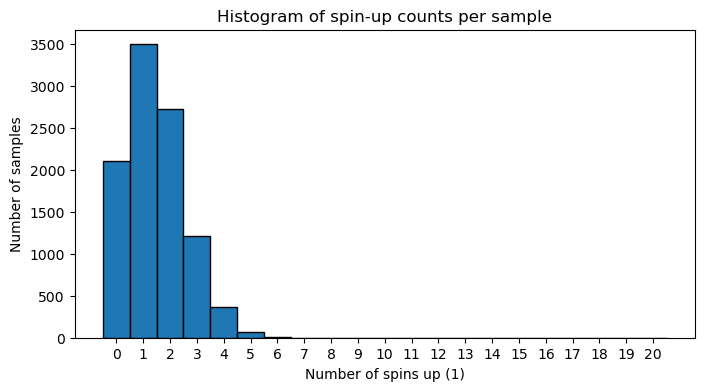

In [53]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [54]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in loader_amp:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.0959375 , 0.09953125, 0.09640625, 0.0984375 , 0.09984375,
       0.10265625, 0.09671875, 0.101875  , 0.109375  , 0.09921875],      dtype=float32)

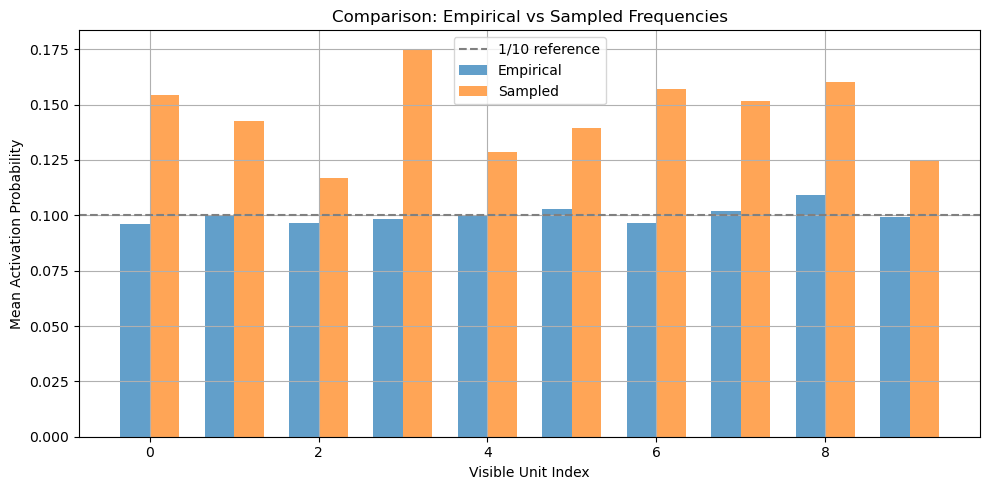

In [55]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()